In [1]:
import findspark 
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("ClusteringApp").getOrCreate()
spark

In [3]:
df=spark.read.option("header","true").csv('D:\\titanic.csv',inferSchema=True)
df.toPandas()

,Survived,Pclass,Name,Sex,Age,SiblingsSpouses Aboard,ParentsChildren Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


In [4]:
df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SiblingsSpouses Aboard: integer (nullable = true)
 |-- ParentsChildren Aboard: integer (nullable = true)
 |-- Fare: double (nullable = true)



In [6]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [7]:
def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
print("Null COlumns calc list " ,null_columns_calc_list)
#schema = StructType([StructField("M1", IntegerType(), True),StructField("M2", IntegerType(), True),StructField("M3", IntegerType(), True)])
#spark.createDataFrame(data=[(5,6,7),(5,6,7)],schema=schema).show()
# spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

Null COlumns calc list  []


In [8]:
from pyspark.ml.feature import StringIndexer
g=StringIndexer(inputCol='Sex',outputCol='Gen_Col')
v=g.fit(df).transform(df)
df=v.drop('Sex','Name')

In [9]:
from pyspark.ml.feature import VectorAssembler
input_columns = df.columns 
input_columns = input_columns[1:] 
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_kmeans = vecAssembler.transform(df)
df_kmeans.limit(5).toPandas()

,Survived,Pclass,Age,SiblingsSpouses Aboard,ParentsChildren Aboard,Fare,Gen_Col,features
0,0,3,22.0,1,0,7.2500,0.0,"[3.0, 22.0, 1.0, 0.0, 7.25, 0.0]"
1,1,1,38.0,1,0,71.2833,1.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0]"
2,1,3,26.0,0,0,7.9250,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 1.0]"
3,1,1,35.0,1,0,53.1000,1.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0]"
4,0,3,35.0,0,0,8.0500,0.0,"[3.0, 35.0, 0.0, 0.0, 8.05, 0.0]"


In [10]:
# find the best amount of cluster
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

kmax=50
kmcost=np.zeros(kmax)
for k in range(2,kmax):
    kmeans=KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model=kmeans.fit(df_kmeans)
    
    predictions=model.transform(df_kmeans)
    evaluator=ClusteringEvaluator()
    kmcost[k]=evaluator.evaluate(predictions)
    
print(kmcost)

[0.         0.         0.97406795 0.91497372 0.81922853 0.78148193
 0.60385217 0.49200774 0.61372646 0.60968895 0.60434023 0.62893952
 0.60060975 0.56486044 0.57940103 0.57934825 0.57728547 0.52787228
 0.59366382 0.57951056 0.59147428 0.5292159  0.56337806 0.59997166
 0.54245571 0.57523814 0.57085226 0.54190741 0.59590609 0.51410167
 0.52373749 0.54415796 0.52777644 0.5505415  0.52814098 0.53622115
 0.52010412 0.53037725 0.55355835 0.52338034 0.5304636  0.53219158
 0.51564929 0.51189597 0.51575261 0.51651365 0.51870184 0.53031097
 0.49229003 0.5214153 ]


In [11]:
predictions.limit(5).toPandas()

,Survived,Pclass,Age,SiblingsSpouses Aboard,ParentsChildren Aboard,Fare,Gen_Col,features,prediction
0,0,3,22.0,1,0,7.2500,0.0,"[3.0, 22.0, 1.0, 0.0, 7.25, 0.0]",0
1,1,1,38.0,1,0,71.2833,1.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0]",27
2,1,3,26.0,0,0,7.9250,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 1.0]",44
3,1,1,35.0,1,0,53.1000,1.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0]",11
4,0,3,35.0,0,0,8.0500,0.0,"[3.0, 35.0, 0.0, 0.0, 8.05, 0.0]",10


Text(0, 0.5, 'cost')

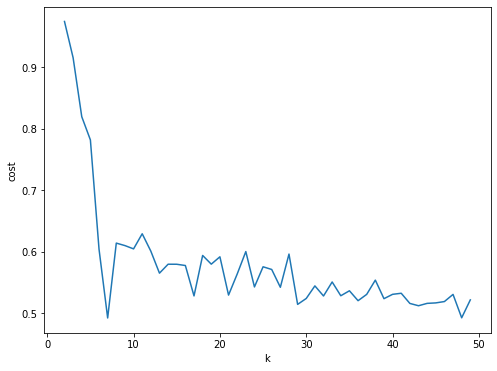

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax=plt.subplots(1,1, figsize=(8,6))
ax.plot(range(2,kmax),kmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [13]:
# Bisecting kmeans
from pyspark.ml.clustering import BisectingKMeans

kmax=50
bkmcost=np.zeros(kmax)
for k in range(2,kmax):
    bkmeans=BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model=bkmeans.fit(df_kmeans)
    
    predictions=model.transform(df_kmeans)
    evaluator=ClusteringEvaluator()
    bkmcost[k]=evaluator.evaluate(predictions)
    
print(bkmcost)

[0.         0.         0.91596326 0.73296867 0.76190436 0.57079327
 0.5500682  0.54229694 0.56464333 0.56315445 0.58293439 0.57494441
 0.59315855 0.59361872 0.54084177 0.54111963 0.53905285 0.42869682
 0.43175538 0.4489439  0.47591945 0.42391204 0.46085088 0.45670499
 0.46097521 0.46510133 0.45238088 0.45070103 0.45114411 0.4533729
 0.46442906 0.46068531 0.3532594  0.42572652 0.41899251 0.43645081
 0.47906516 0.44312442 0.44400555 0.44426316 0.43307468 0.43747857
 0.44244078 0.44621084 0.44614205 0.4378218  0.43364021 0.32217909
 0.43045532 0.42918461]


Text(0, 0.5, 'cost')

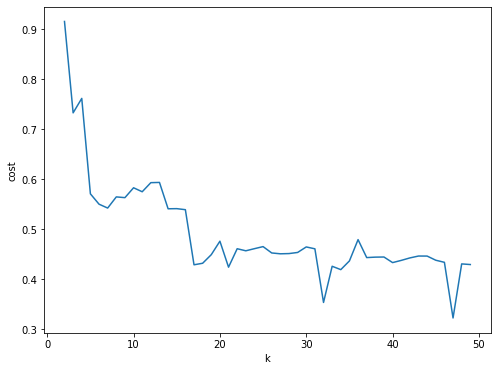

In [14]:
fig, ax=plt.subplots(1,1, figsize=(8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [15]:
# comparision between two kmeans
def compare(bkmcost,kmcost):
    diff=[]
    for k in range(2,kmax,5):
        temp=k,(kmcost[k]-bkmcost[k])
        diff.append(temp)
    return(diff)

diff_list=compare(bkmcost,kmcost)
diff_list

[(2, 0.05810468814615222),
 (7, -0.050289200622376296),
 (12, 0.007451197678912225),
 (17, 0.0991754547164479),
 (22, 0.10252718010401579),
 (27, 0.09120638407173265),
 (32, 0.17451704375977195),
 (37, 0.0872528248352345),
 (42, 0.07320850280325342),
 (47, 0.2081318828817355)]

Text(0, 0.5, 'cost')

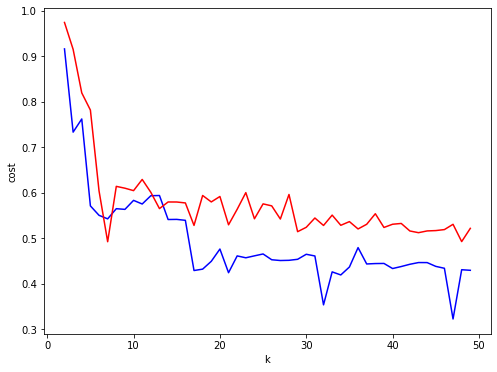

In [16]:
#Let's plot both graphs together
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax],color='blue')
ax.plot(range(2,kmax),kmcost[2:kmax],color='red')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [17]:
# Final model
k = 8
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)

# bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
# model = bkmeans.fit(df_kmeans)

# Make predictions
predictions = model.transform(df_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print(" ")

# Shows the cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6137264596864127
 
Cluster Centers: 
[ 2.77136259 25.2817552   0.2147806   0.09930716 10.12267991  0.28637413]
[1.00000000e+00 3.53333333e+01 0.00000000e+00 3.33333333e-01
 5.12329200e+02 3.33333333e-01]
[  1.          32.29411765   0.88235294   1.17647059 238.18725294
   0.64705882]
[  1.       32.96625   0.59375   0.8125  131.87955   0.6875 ]
[ 2.0441989  46.1878453   0.21546961  0.37569061 20.46325856  0.25966851]
[ 1.60294118 31.97058824  1.44117647  0.69117647 54.88284559  0.42647059]
[ 2.58163265  8.7372449   1.69387755  1.19387755 26.38516122  0.5       ]
[ 1.10909091 38.07272727  0.65454545  0.32727273 80.79712182  0.56363636]
